In [1]:
%matplotlib inline
import sys
from astropy import table
import numpy as np
from pathlib import Path
from matplotlib import colors, cm
from astropy import convolution
import cmocean
import betterplotlib as bpl

bpl.set_style()

In [2]:
home_dir = Path("../").resolve()
data_dir = home_dir / "data"

In [3]:
sys.path.append(str(home_dir / "pipeline"))
import utils

In [4]:
catalogs = []
for galaxy_dir in data_dir.iterdir():
    cat_name = galaxy_dir / "size" / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
    final_cat = table.Table.read(str(cat_name), format="ascii.ecsv")
    catalogs.append(final_cat)
    
big_catalog = table.vstack(catalogs, join_type="inner")

In [5]:
mask1 = big_catalog["mass_msun"] > 3e4
mask2 = big_catalog["r_eff_pc_rmax_15pix_best"] < 0.7
maskg = big_catalog["good"]

mask = np.logical_and(mask1, mask2)
mask = np.logical_and(mask, maskg)

In [6]:
def make_cumulative_histogram(values, normed=True):
    """
    Create the line to be plotted for a cumulative histogram

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    if normed:
        ys = ys / np.max(ys)
    return sorted_values, ys

In [7]:
scales = {"chi_2_reduced": "linear",
          "Q_probability": "log",
          "mass_msun": "log",
          "age_yr": "log",
          "CI": "linear",
          "E(B-V)": "linear"}

limits = {"chi_2_reduced": [0, 20],
          "Q_probability": [1e-6, 1.5],
          "mass_msun": [1, 1e7],
          "age_yr": [5e5, 2e10],
          "CI": [1, 2],
          "E(B-V)": [-0.1, 2]}

names = {"chi_2_reduced": "Reduced $\chi^2$",
         "Q_probability": "Q Probability",
         "mass_msun": "Cluster Mass [M$_\odot$]",
         "age_yr": "Age [yr]",
         "CI": "Concentration Index",
         "E(B-V)": "E(B-V)"}

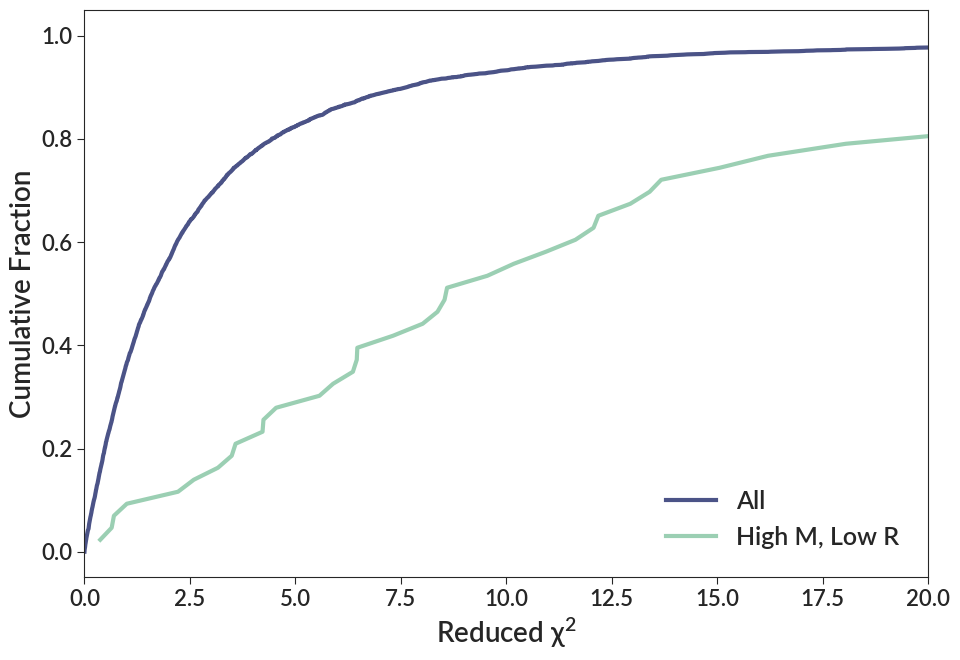

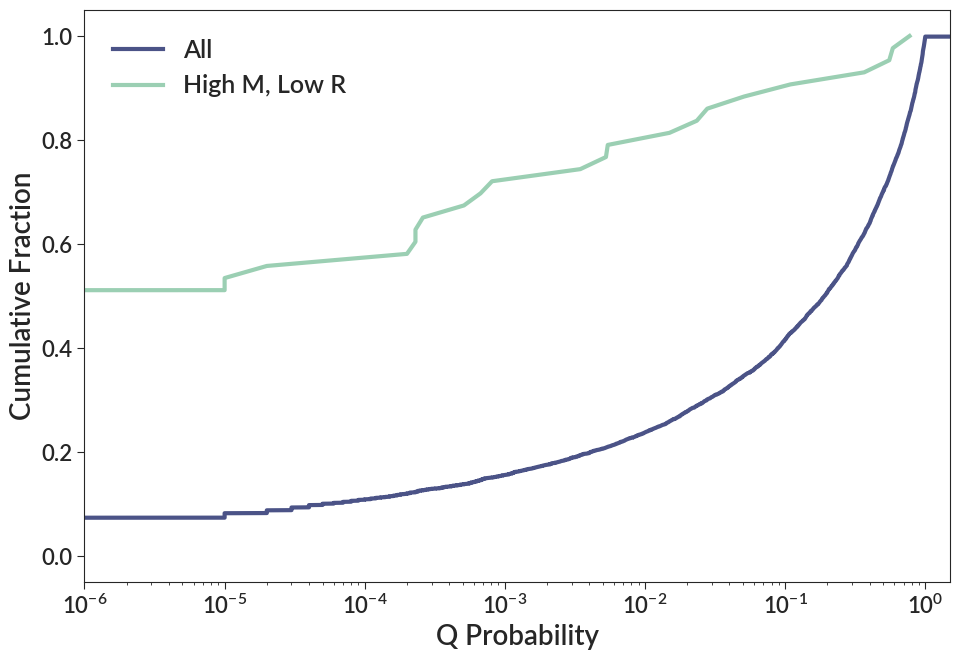

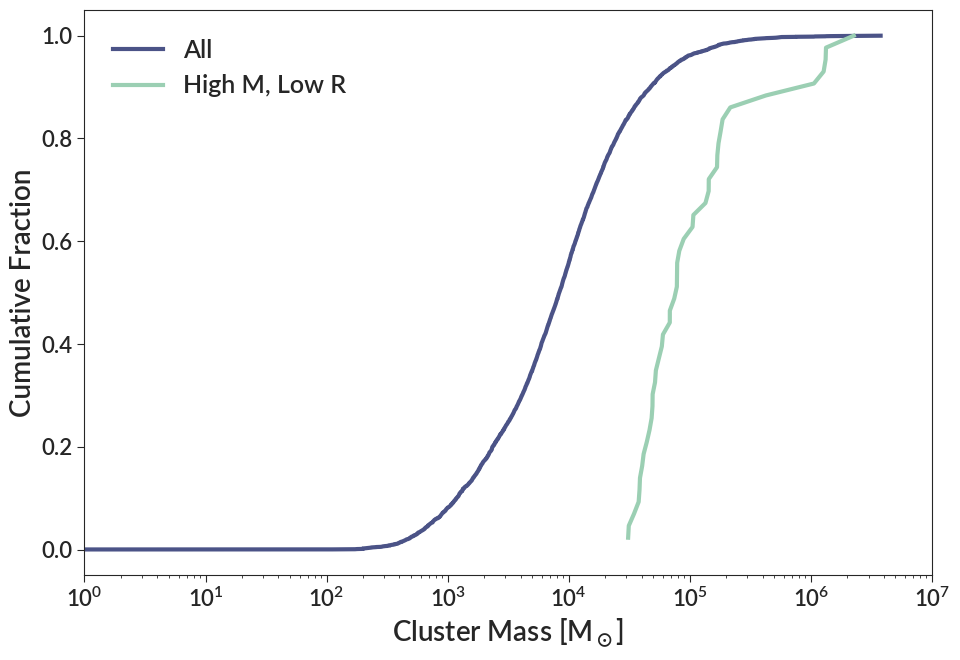

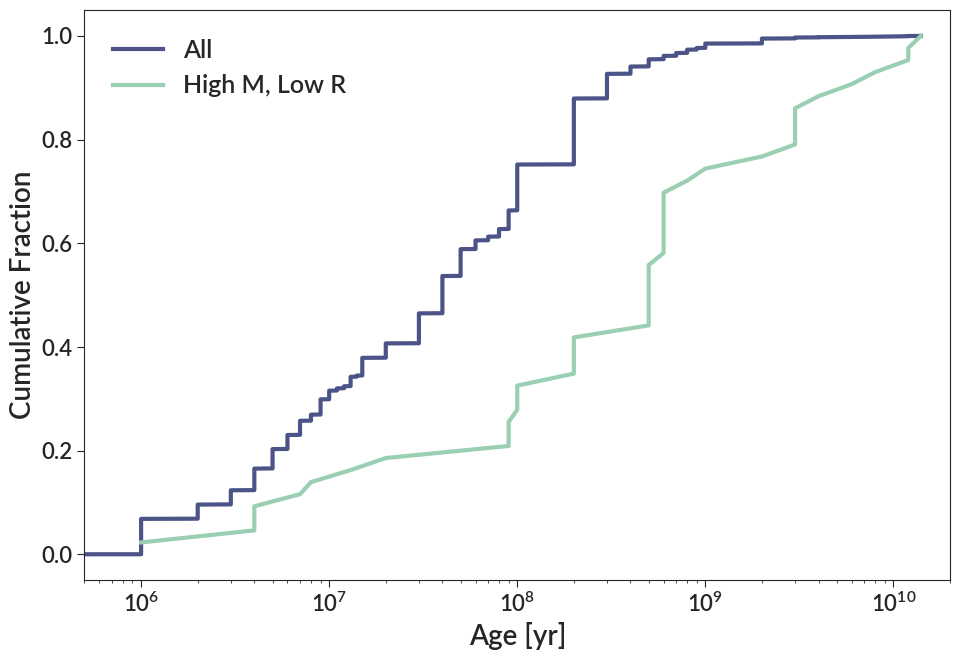

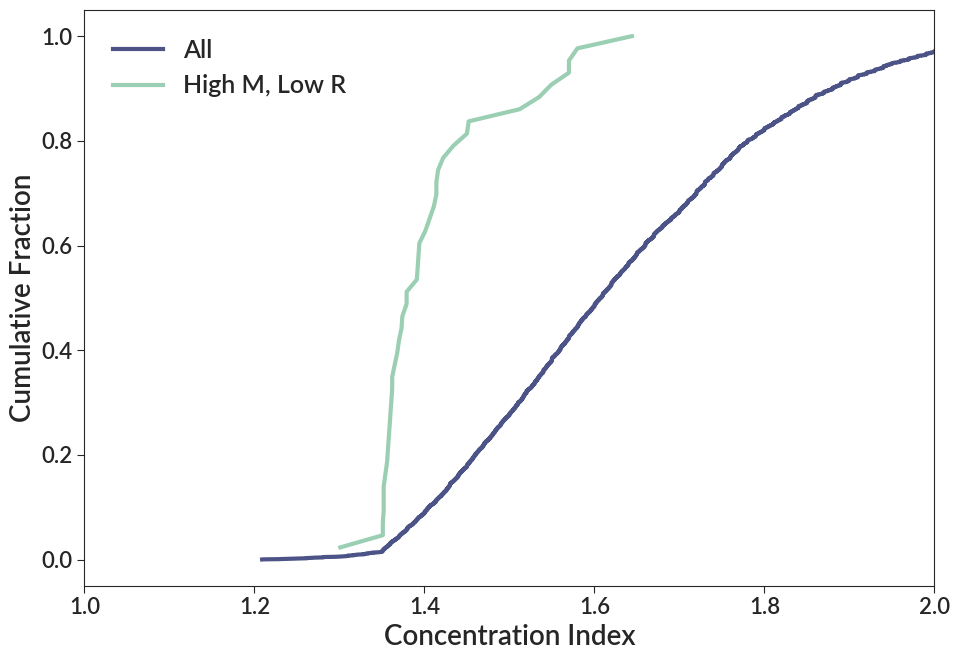

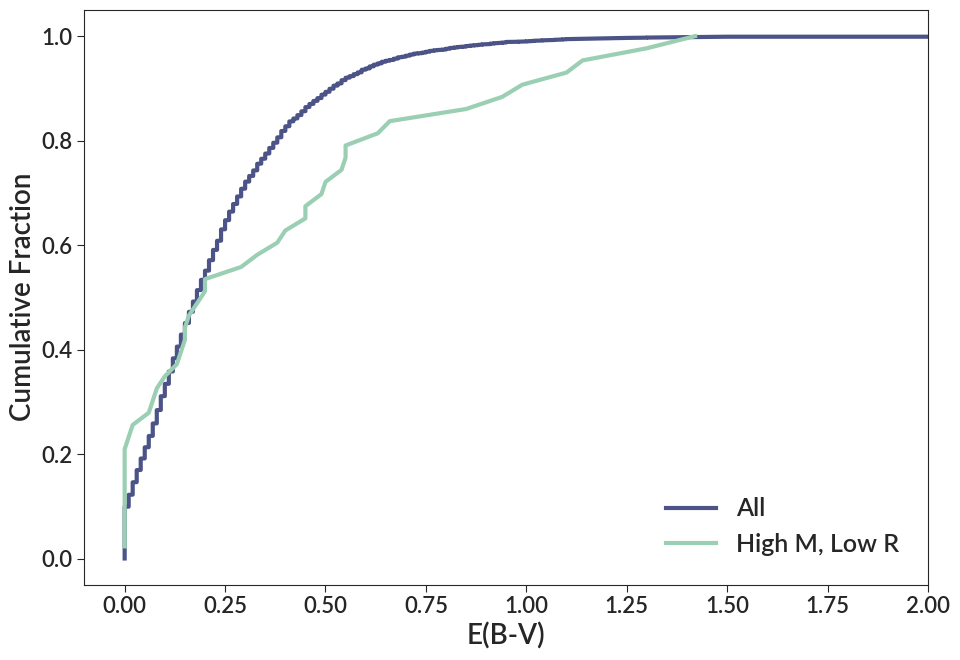

In [8]:
for quantity in scales:
    fig, ax = bpl.subplots()
    ax.plot(*make_cumulative_histogram(big_catalog[quantity][maskg]), label="All")
    ax.plot(*make_cumulative_histogram(big_catalog[quantity][mask]), label="High M, Low R")
    ax.set_limits(*limits[quantity])
    ax.set_xscale(scales[quantity])
    ax.legend()
    ax.add_labels(names[quantity], "Cumulative Fraction")

# Correlations

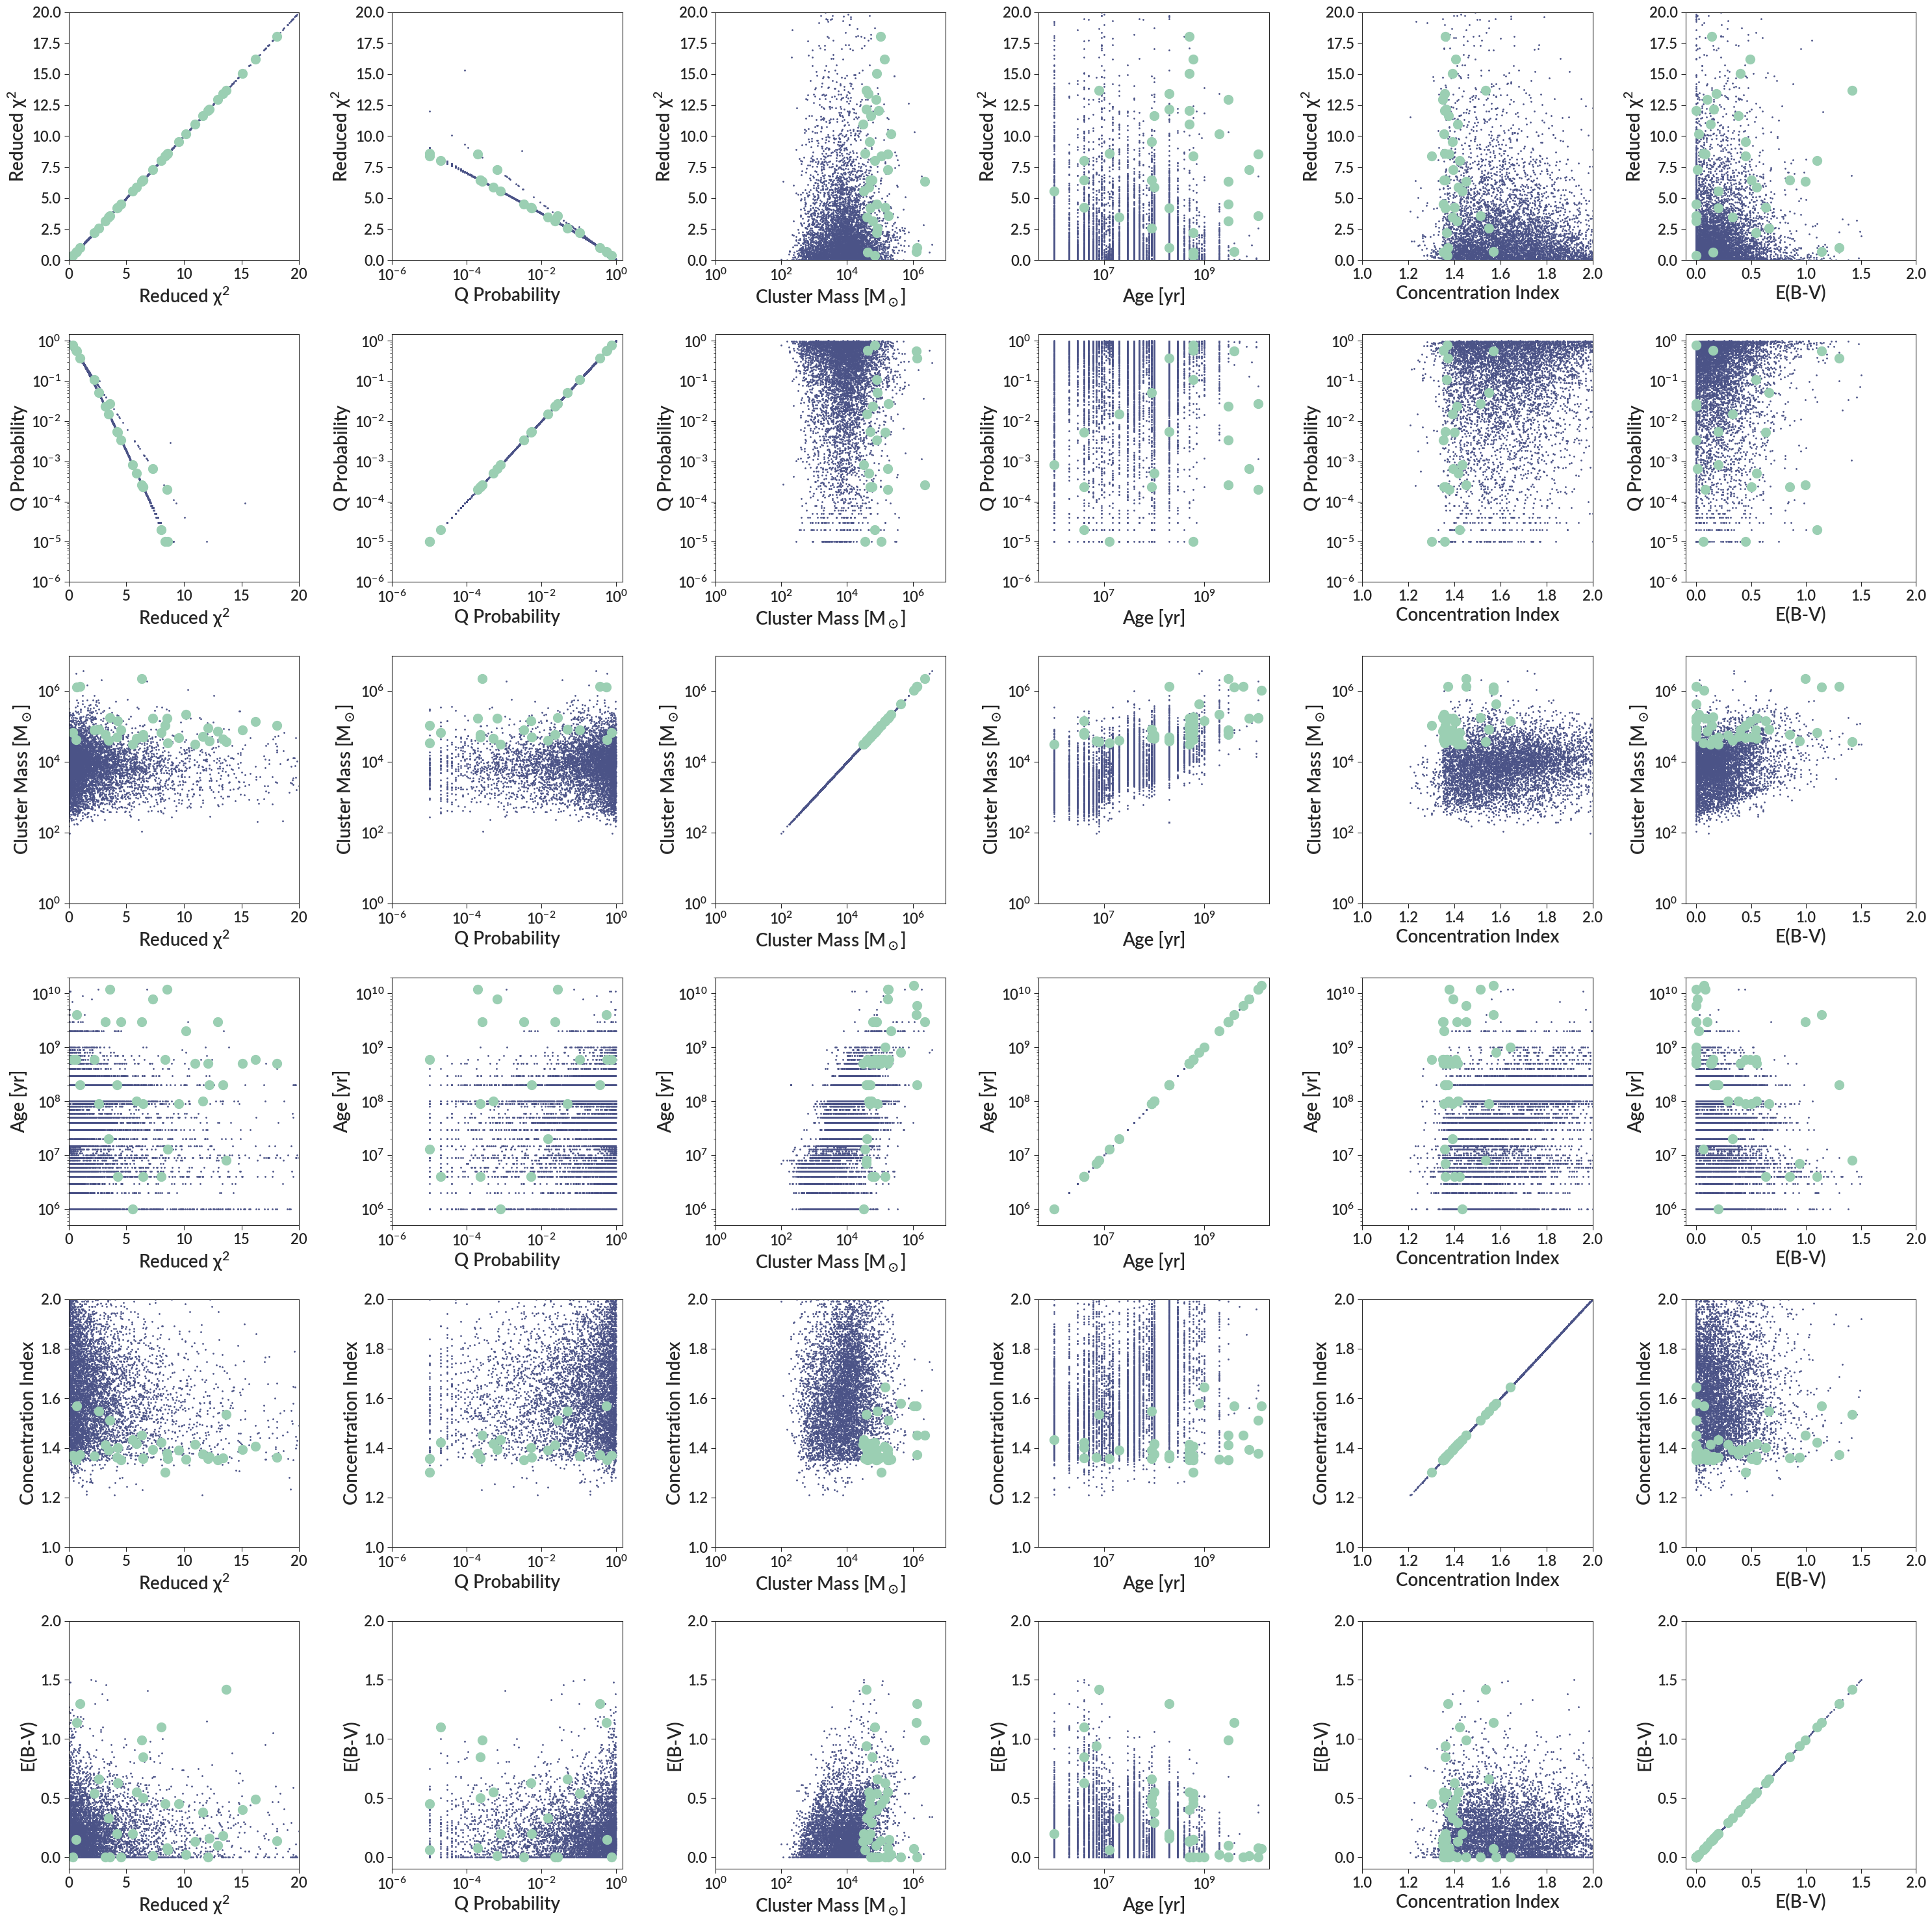

In [9]:
fig, axs = bpl.subplots(ncols=len(scales), nrows=len(scales), 
                       figsize=[5*len(scales), 5*len(scales)])
quantities = scales.keys()

for idx1, quantity1 in enumerate(quantities):
    for idx2, quantity2 in enumerate(quantities):
        ax = axs[idx2][idx1]
        
        ax.scatter(big_catalog[quantity1][maskg], big_catalog[quantity2][maskg], 
                   label="All", s=1, alpha=1)
        ax.scatter(big_catalog[quantity1][mask], big_catalog[quantity2][mask], 
                   label="High M, Low R", s=100, alpha=1)
        ax.set_limits(*limits[quantity1], *limits[quantity2])
        ax.set_xscale(scales[quantity1])
        ax.set_yscale(scales[quantity2])
        ax.add_labels(names[quantity1], names[quantity2])

# It looks like `Q_probability` is the biggest predictor. See how many we'd throw out with different cuts

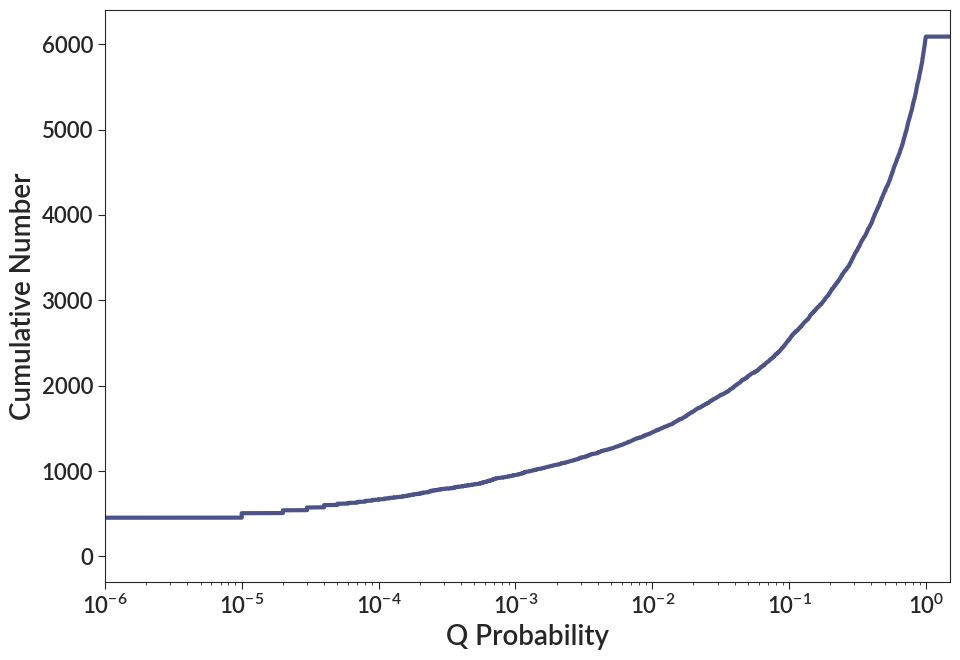

In [10]:
quantity = "Q_probability"
fig, ax = bpl.subplots()
ax.plot(*make_cumulative_histogram(big_catalog[quantity][maskg], normed=False), label="All")
ax.set_limits(*limits[quantity])
ax.set_xscale(scales[quantity])
ax.add_labels(names[quantity], "Cumulative Number")

And see where they are in the mass-size plane

In [11]:
q_cuts = [-1, 0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [12]:
print(f"{'q_cut':>6} - N")
for q_cut in q_cuts:
    mask = np.logical_and.reduce(
        [
            big_catalog["good"],
            big_catalog["mass_msun"] > 0,
            big_catalog["mass_msun_max"] > 0,
            big_catalog["mass_msun_min"] > 0,
            big_catalog["mass_msun_min"] <= big_catalog["mass_msun"],
            big_catalog["mass_msun_max"] >= big_catalog["mass_msun"],
            big_catalog["Q_probability"] > q_cut,
        ]
    )
    print(f"{q_cut:>6.2g} - {np.sum(mask)}")

 q_cut - N
    -1 - 5983
     0 - 5575
 1e-05 - 5526
0.0001 - 5379
 0.001 - 5105
  0.01 - 4626
   0.1 - 3547


 q_cut -      M16 -      M50 -      M84
    -1 -      nan -      nan -      nan
     0 -  1522.32 -  9521.40 - 28344.80
 1e-05 -  1606.20 -  8987.00 - 28388.00
0.0001 -  1606.52 -  9630.20 - 28541.20
 0.001 -  1678.92 -  9463.40 - 27365.20
  0.01 -  1758.40 - 10200.00 - 28244.00
   0.1 -  1946.00 - 10950.00 - 30974.00


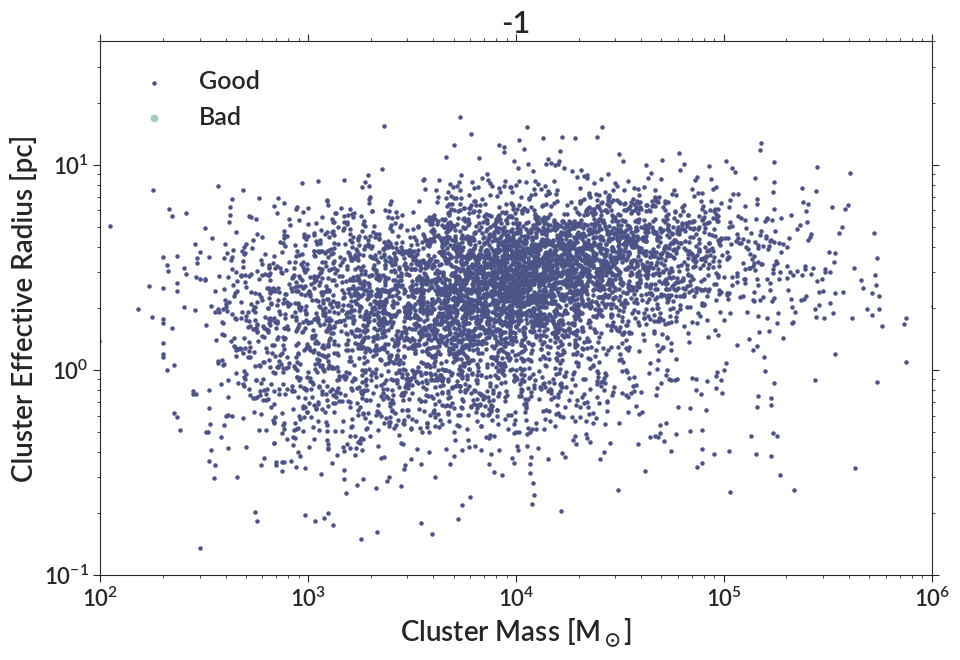

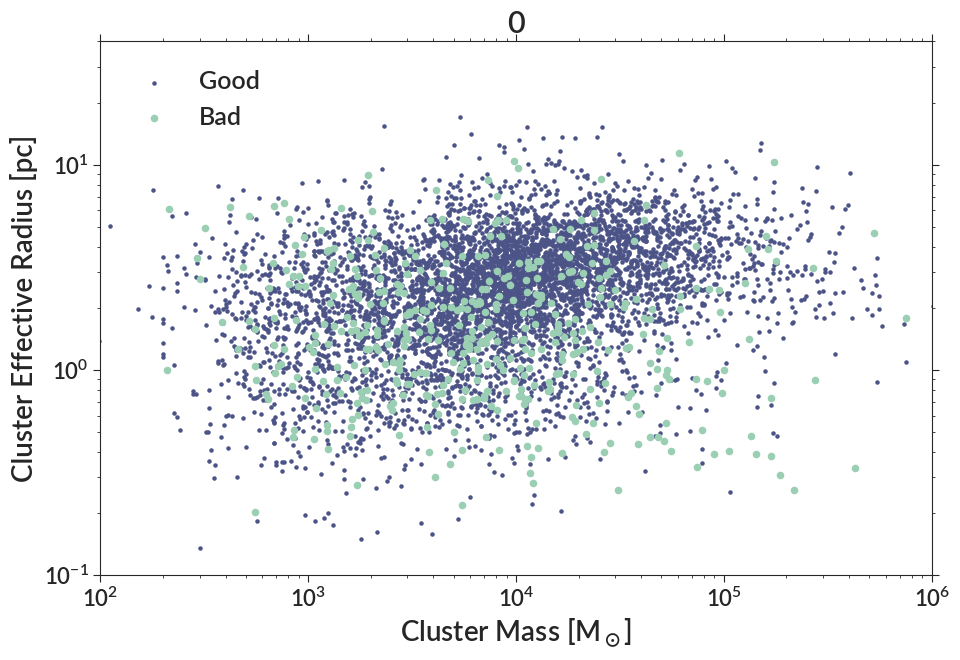

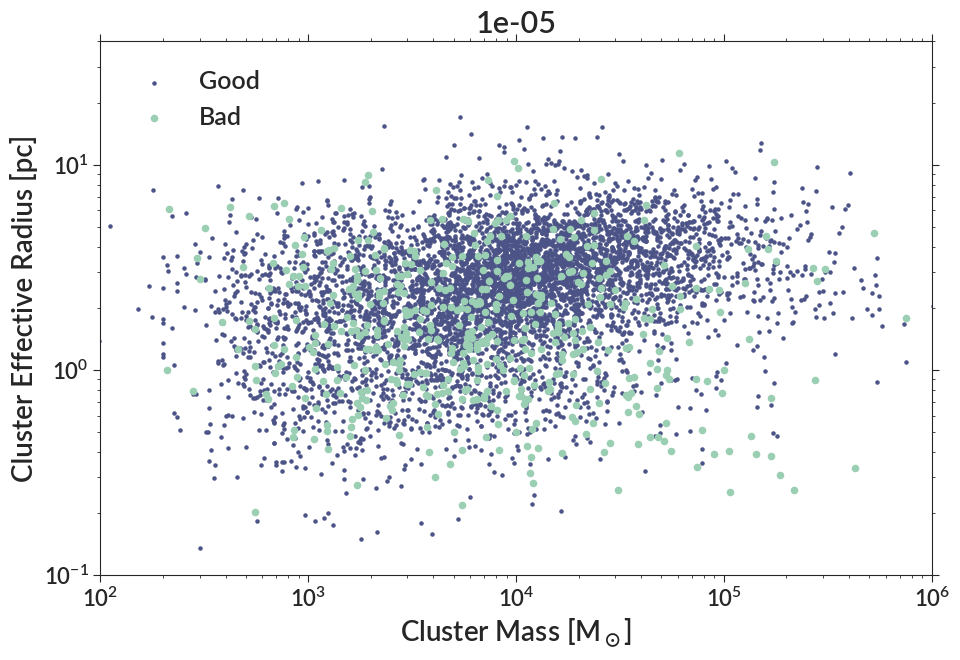

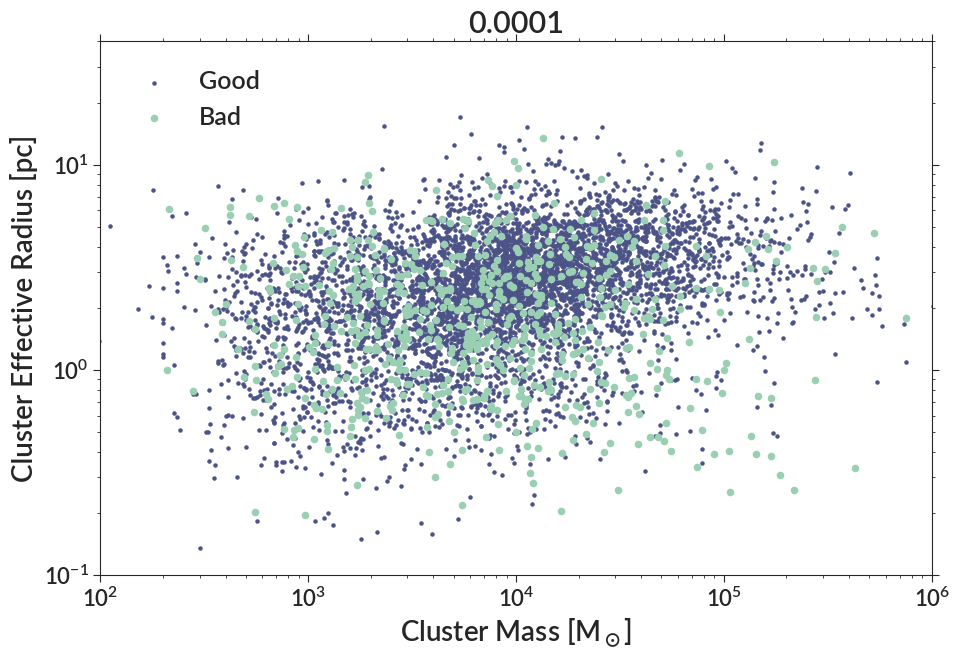

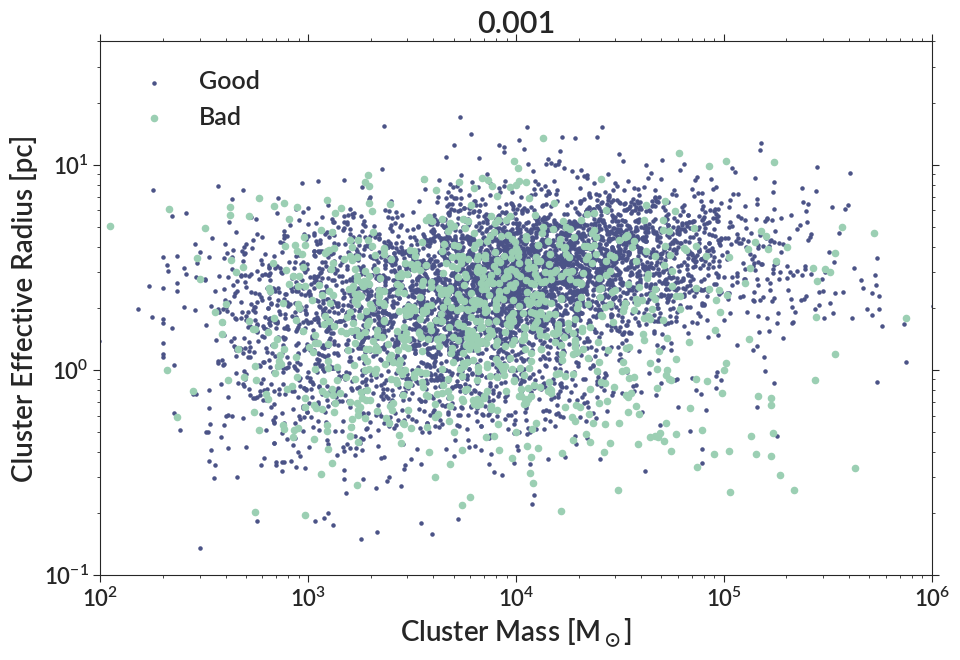

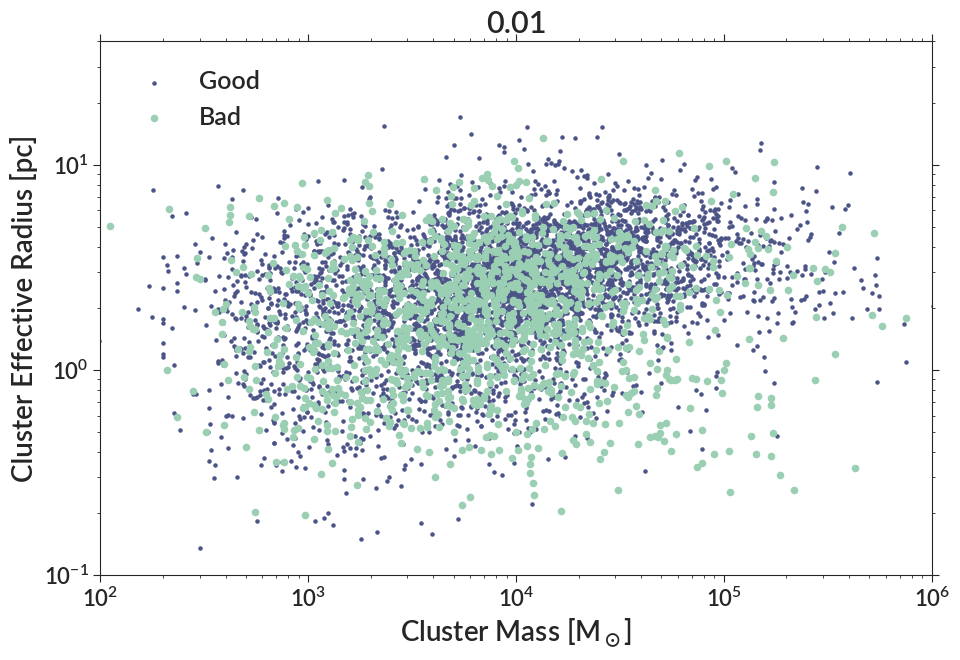

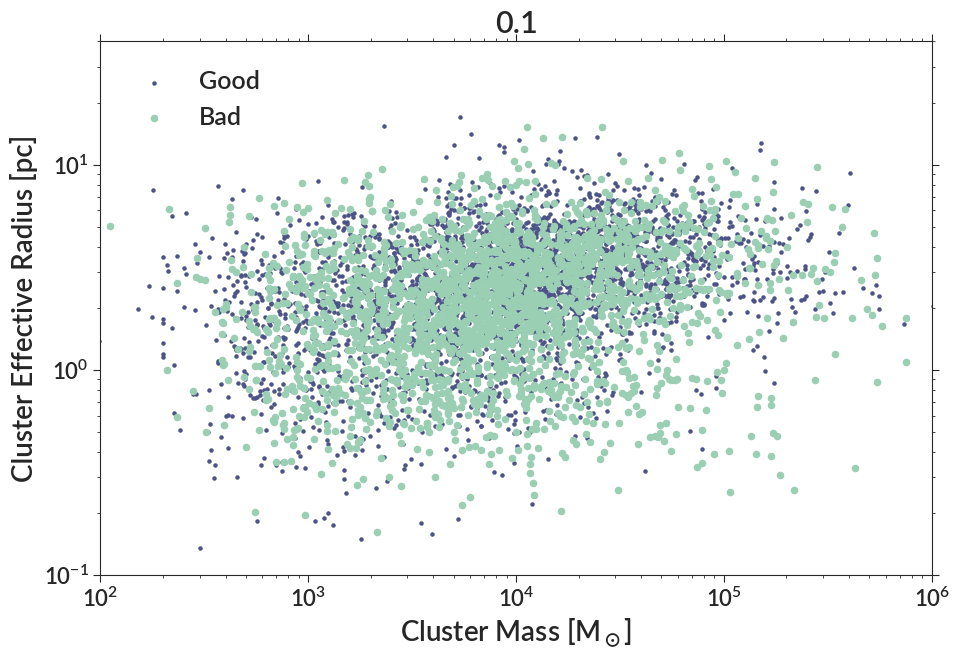

In [13]:
print(f"{'q_cut':>6} - {'M16':>8} - {'M50':>8} - {'M84':>8}")
for q_cut in q_cuts:
    cut_mask_good = big_catalog["Q_probability"] > q_cut
    cut_mask_bad = ~cut_mask_good
    
    cut_mask_good = np.logical_and(cut_mask_good, maskg)
    cut_mask_bad = np.logical_and(cut_mask_bad, maskg)
    
    masses_bad = big_catalog["mass_msun"][cut_mask_bad]
    if len(masses_bad) > 0:
        low, med, hi = np.percentile(masses_bad, [16, 60, 84])
    else:
        low, med, hi = np.nan, np.nan, np.nan
    
    print(f"{q_cut:>6.2g} - {low:>8.2f} - {med:>8.2f} - {hi:>8.2f}")
    
    fig, ax = bpl.subplots()
    ax.scatter(big_catalog["mass_msun"][cut_mask_good], 
               big_catalog["r_eff_pc_rmax_15pix_best"][cut_mask_good], \
               s=5, alpha=1, label='Good')
    ax.scatter(big_catalog["mass_msun"][cut_mask_bad], 
               big_catalog["r_eff_pc_rmax_15pix_best"][cut_mask_bad], 
               s=20, alpha=1, label="Bad")

    
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_limits(1e2, 1e6, 0.1, 40)
    ax.add_labels("Cluster Mass [M$_\odot$]", "Cluster Effective Radius [pc]", f"{q_cut:.2g}")
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.legend(loc=2, frameon=False)
    